# Validation of parallax correction on synthetic data.

In this notebook, we will build a synthetic dataset and apply parallax effect to it using raytracing.
Then this data will be deconvoluted with different methods.
Finally we will compare the calibration of:
* the initial synthetic dataset,
* the parallax blurred dataset,
* the deconvoluted dataset,
* assess the parallax correction implemented in pyFAI without deconvolution.

In this tutorial, we will use `Titan` detector (2048x2048 pixels of 60µm each) with 1mm Si sensor at 20 keV.
The sample is a perfect LaB6 placed just 7 cm in front of the detector in orthogonal geometry.

Attenion, the `Titan` detector has a Gadox phosphor, the usage of Silicon is just for demonstration of the parallax effect. The warnings about the sensor are expected.

In [1]:
%matplotlib inline
# %matplotlib widget
# use `widget` instead of `inline` for better user-experience. `inline` allows to store plots into notebooks.

In [2]:
import time
start_time = time.perf_counter()
import json
import numpy
from matplotlib.pyplot import subplots
from scipy.sparse import csr_matrix, csc_matrix, linalg, save_npz

import h5py
import fabio
import pyFAI
import pyFAI.units
import pyFAI.detectors
from pyFAI.calibrant import get_calibrant
from pyFAI.detectors.sensors import Si_MATERIAL
from pyFAI.gui import jupyter
import hdf5plugin

from pyFAI.ext.parallax_raytracing import Raytracing
numpy.random.seed(0)

ai = pyFAI.load({"dist": 7e-2,
                 "poni1": 6e-2,
                 "poni2": 6e-2,
                 "detector": "Titan", 
                 "detector_config":{"sensor":{"material": "Si", 
                                              "thickness":1e-3}}})
energy = ai.energy = 20  # keV
thickness = ai.detector.sensor.thickness
print(ai)

Detector Titan 2k x 2k	 PixelSize= 60µm, 60µm	 BottomRight (3)	 Si,1mm
Wavelength= 0.619921 Å	Parallax: off
SampleDetDist= 7.000000e-02 m	PONI= 6.000000e-02, 6.000000e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 70.000 mm	Center: x=1000.000, y=1000.000 pix	Tilt= 0.000° tiltPlanRotation= 0.000° λ= 0.620Å


## Absorption coefficient at 20 keV

In [3]:
print(f"µ = {Si_MATERIAL.mu(energy, unit="cm"):.1f} cm^-1 "
      f"hence absorption efficiency for 1mm: {100*Si_MATERIAL.absorbance(energy, thickness):.1f} %")
mu = Si_MATERIAL.mu(energy, unit="m")

µ = 10.4 cm^-1 hence absorption efficiency for 1mm: 64.6 %


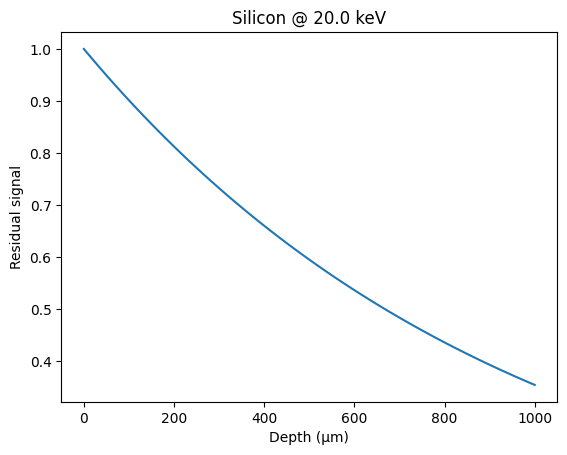

In [4]:
depth = numpy.linspace(0, 1000, 100)
res = [1-Si_MATERIAL.absorbance(energy, d, "µm") for d in depth]
fig, ax = subplots()
ax.plot(depth, res, "-")
ax.set_xlabel("Depth (µm)")
ax.set_ylabel("Residual signal")
ax.set_title(f"Silicon @ {energy:.1f} keV");

This is consistent with:
[henke.lbl.gov](http://henke.lbl.gov/optical_constants/filter2.html) or 
[web-docs.gsi.de](https://web-docs.gsi.de/~stoe_exp/web_programs/x_ray_absorption/index.php)

Let's buid some fake diffraction data: LaB6 is providing nice rings:

In [5]:
fwhm = 0.05
LaB6 = get_calibrant("LaB6")
LaB6.wavelength = ai.wavelength
xrpd = LaB6.fake_xrpdp(1000, (0,55), resolution=fwhm)
img = numpy.random.poisson(LaB6.fake_calibration_image(ai, resolution=fwhm, Imax=1e6)).astype("int32")

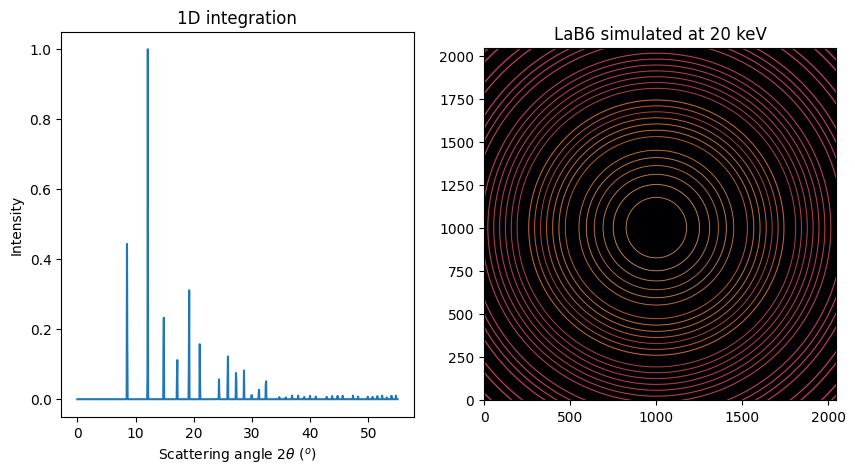

In [6]:
fig, ax = subplots(1, 2, figsize=(10,5))
jupyter.plot1d(xrpd, ax=ax[0])
jupyter.display(img, ax=ax[1])
ax[1].set_title(f"LaB6 simulated at {energy} keV");

This frame can be calibrated with `pyFAI-calib2` for example in order to retrieve the initial parameters.
Here are the found distance and energy found with the measured error:
* Distance: 70.019mm (δ:19µm)
* Energy: 20.004 keV (δ:4eV)
* Center: 59.99997 mm  (δ:0.3µm) (calibrated without tilt)
As expected, pyFAI is able to retrieve the configuration of the simulated setup.

Now we can model the parallax in the detector using raytracing.

## Modeling of the detector:

The detector is represented as a 2D array of voxels.

In [7]:
detector= ai.detector
print(detector)

vox = detector.pixel2 # this is not a typo
voy = detector.pixel1 # x <--> axis 2
voz = thickness

print(f"Voxel size: (x:{vox}, y:{voy}, z:{voz})")
print(f"Maximum incidence angle : {numpy.rad2deg(numpy.arcsin(ai.sin_incidence(d1=None, d2=None))).max():.1f}°")

Detector Titan 2k x 2k	 PixelSize= 60µm, 60µm	 BottomRight (3)	 Si,1mm
Voxel size: (x:6e-05, y:6e-05, z:0.001)
Maximum incidence angle : 51.8°


The intensity grabbed in this voxel is the triple integral of the absorbed signal coming from this pixel or from the neighboring ones.

There are 3 ways to perform this intergral:
* Volumetric analytic integral. Looks feasible with a change of variable in the depth
* Slice per slice, the remaining intensity depand on the incidence angle + pixel splitting between neighbooring pixels
* raytracing: the decay can be solved analytically for each ray, one has to throw many ray to average out the signal.

For sake of simplicity, this integral will be calculated numerically using this raytracing algorithm.
http://www.cse.yorku.ca/~amana/research/grid.pdf

Knowing the input position for a X-ray on the detector and its propagation vector, this algorithm allows us to calculate  the length of the path in all voxel it crosses in a fairly efficient way.

To speed up the calculation, we will use a few tricks:
* One ray never crosses more than 16 pixels, which is reasonable considering the incidance angle 
* we use numba to speed-up the calculation of loops in python
* We will allocate the needed memory by chuncks of 1 million elements


In [8]:
ai.enable_parallax(True)
rt = Raytracing(ai)
print("Performance of raytracing in Cython:")
%time pre_csr = rt.calc_csr(4)

Performance of raytracing in Cython:


CPU times: user 26.2 s, sys: 1.08 s, total: 27.3 s
Wall time: 1.1 s


In [9]:
rt = Raytracing(ai, buffer_size=64)
print("Performance of raytracing in Cython:")
%time pre_csr = rt.calc_csr(4)

Performance of raytracing in Cython:
CPU times: user 42.7 s, sys: 1.25 s, total: 44 s
Wall time: 1.62 s


## Validation of the CSR matrix obtained:

For this we will build a simple 2D image with one pixel in a regular grid and calculate the effect of the transformation calculated previously on it. 

In [10]:
%time csr = csr_matrix(rt.calc_csr(128)) # 16k rays per pixel!
sparse = csr.T
save_npz("Sparse_titan.npz",sparse)

CPU times: user 8h 41min 30s, sys: 12.4 s, total: 8h 41min 42s
Wall time: 11min 20s


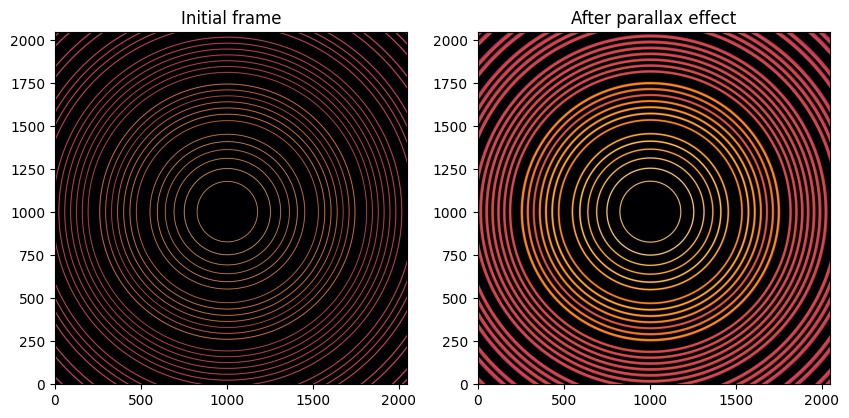

In [11]:
# Blurring an diffraction frame:
img_blurred = sparse.dot(img.ravel()).reshape(img.shape).astype("int32")
fig, ax = subplots(1,2, figsize=(10,5))
jupyter.display(img, ax=ax[0])
jupyter.display(img_blurred, ax=ax[1])
ax[0].set_title("Initial frame")
ax[1].set_title("After parallax effect");

In [12]:
with h5py.File("parallax_frames.h5", "w") as h:
    for k,v in ai.get_config().items():
        try:
            h[f"poni/{k}"] = v
        except TypeError:
            h[f"poni/{k}"] = json.dumps(v)
    h["sample"] = "LaB6"
    h.create_dataset("no_parallax", data=img, compression=hdf5plugin.Bitshuffle())
    h.create_dataset("parallax", data=img_blurred, compression=hdf5plugin.Bitshuffle())

After application of the parallax effect via a sparse matrix multiplication, the rings looks broader.
This frame can be calibrated to assess the experimental setup, like the original one. 

Here are the results of the calibration:
* distance: 70.441mm (δ:441µm)
* energy: 20.059keV (δ:59eV)
* center: 59.997mm (δ:3µm)

Since the parallax effect changes the apparant 2θ position of the rays as function of the incidence angle, the quality of the geometry refined is worse. Experimentally, it is not uncommon that rings start to overlap for angles above 30°, this is why it is recommanded to calibrate only up to 30° angle without parallax correction.

When activating the parallax correction in pyFAI-calib2 with a silicon sensor of 1000µm, the calculated geometry is the following:
* distance: 69.977mm (δ:23µm)
* energy: 20.045keV (δ:45eV)
* center: 59.998mm (δ:2µm)

Which is much better than without correction. Despite the calibration is slower with parallax activated, there is no comparison with the generation of the sparse matrix or any kind of deconvolution we will see next.

## Inversion of parallax effect

First, let's build a simple image with some dots regularly spaced in the image, a good pattern to assess the quality of the correction.

In [13]:
dummy_image = numpy.ones(detector.shape, dtype="float32")
dummy_image[::5,::5] = 10

dummy_blurred = sparse.dot(dummy_image.ravel()).reshape(detector.shape)

# Least squares refinement of the pseudo-inverse

This is a pseudo inversion with minimisation of the L2 norm:
https://stanford.edu/group/SOL/software/lsmr/LSMR-SISC-2011.pdf

This algorithm is fairly slow, several minutes per image.

In [14]:
# Invert this matrix: see https://arxiv.org/abs/1006.0758
%time res = linalg.lsmr(sparse, dummy_blurred.ravel())
restored_lsmr = res[0].reshape(detector.shape).astype("int32")

/users/kieffer/.venv/py313/lib/python3.13/site-packages/scipy/sparse/linalg/_isolve/lsmr.py:407: RuntimeWarning: overflow encountered in cast
  condA = max(maxrbar, rhotemp) / min(minrbar, rhotemp)
/users/kieffer/.venv/py313/lib/python3.13/site-packages/scipy/sparse/linalg/_isolve/lsmr.py:406: RuntimeWarning: overflow encountered in cast
  minrbar = min(minrbar, rhobarold)


CPU times: user 2h 12min 50s, sys: 11.5 s, total: 2h 13min 2s
Wall time: 12min 20s


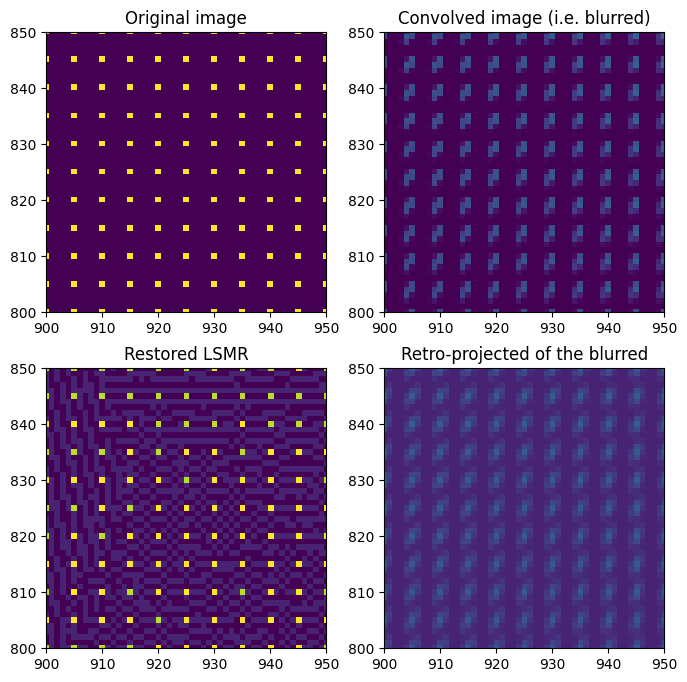

In [15]:
fix, ax = subplots(2,2, figsize=(8,8))
ax[0,0].imshow(dummy_image)
ax[0,0].set_title("Original image")
ax[0,1].imshow(dummy_blurred)
ax[0,1].set_title("Convolved image (i.e. blurred)")
ax[1,1].imshow(sparse.T.dot(dummy_blurred.ravel()).reshape(detector.shape));
ax[1,1].set_title("Retro-projected of the blurred")
ax[1,0].imshow(restored_lsmr)
ax[1,0].set_title("Restored LSMR")
ax[0,0].set_xlim(900,950)
ax[0,0].set_ylim(800,850)
ax[0,1].set_xlim(900,950)
ax[0,1].set_ylim(800,850)
ax[1,1].set_xlim(900,950)
ax[1,1].set_ylim(800,850);
ax[1,0].set_xlim(900,950)
ax[1,0].set_ylim(800,850);

In [16]:
# Now the actual image:
%time res = linalg.lsmr(sparse, img_blurred.ravel())
restored_lsmr = res[0].reshape(detector.shape).astype("int32")

CPU times: user 2h 19min 52s, sys: 2min 22s, total: 2h 22min 15s
Wall time: 8min 34s


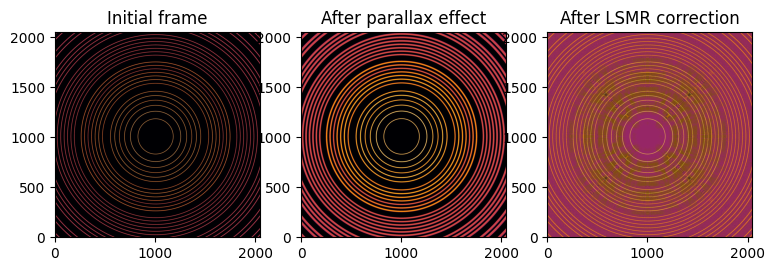

In [17]:
fig, ax = subplots(1,3, figsize=(9,3))
jupyter.display(img, ax=ax[0])
jupyter.display(img_blurred, ax=ax[1])
jupyter.display(restored_lsmr, ax=ax[2])
ax[0].set_title("Initial frame")
ax[1].set_title("After parallax effect");
ax[2].set_title("After LSMR correction");

In [18]:
#Save restored data:
with h5py.File("parallax_frames.h5", "r+") as h:
    h.create_dataset("restored_lsmr", data=restored_lsmr, compression=hdf5plugin.Bitshuffle())

After deconolution of the parallax effect, the calculated geometry is the following:
* distance: 70.018mm (δ:18µm)
* energy: 20.004keV (δ:4eV)
* center: 60.00003mm (δ:30nm)

Which is excellent, but one has to consider the image is a syntetic one which required dozens of minutes of calculation, and it is not artifacts-free as one can observe on the figure just above.

# Pseudo inverse with positivitiy constrain and poissonian noise (MLEM)

The MLEM algorithm was initially developed within the framework of reconstruction of
images in emission tomography [Shepp and Vardi, 1982], [Vardi et al., 1985], [Lange and
Carson, 1984]. Nowadays, this algorithm is employed in numerous tomographic reconstruction
problems and often associated to regularization techniques. It is based on the iterative
maximization of the log-likelihood function.

In [19]:
def iterMLEM_scipy(F, M, R):
    "Implement one step of MLEM"
    #res = F * (R.T.dot(M))/R.dot(F)# / M.sum(axis=-1)
    norm = 1/R.T.dot(numpy.ones_like(F)) 
    cor = R.T.dot(M/R.dot(F))
    res = norm * F * cor
    res[numpy.isnan(res)] = 1.0
    return res

def deconv_MLEM(csr, data, thres=0.2, maxiter=1000):
    R = csr.T
    msk = data<0
    img = data.astype("float32")
    img[msk] = 0.0 # set masked values to 0, negative values could induce errors
    M = img.ravel()
    F0 = R.T.dot(M)
    F1 = iterMLEM_scipy(F0, M, R)
    delta = abs(F1-F0).max()
    for i in range(maxiter):
        if delta<thres:
            break
        F2 = iterMLEM_scipy(F1, M, R)
        delta = abs(F1-F2).max()
        if i%100==0:
            print(i, delta)
        F1 = F2
        i+=1
    print(i, delta)
    return F2.reshape(img.shape)

%time res = deconv_MLEM(sparse, dummy_blurred, 1e-4)

0 4.237849
100 0.021839142
200 0.010632992
300 0.0063171387
400 0.0042324066
500 0.0032405853
600 0.002550602
700 0.002192974
800 0.0019059181
900 0.001657486
1000 0.0014390945
CPU times: user 13min 51s, sys: 373 ms, total: 13min 51s
Wall time: 13min 52s


In [20]:
restored_mlem = res.astype("int32")

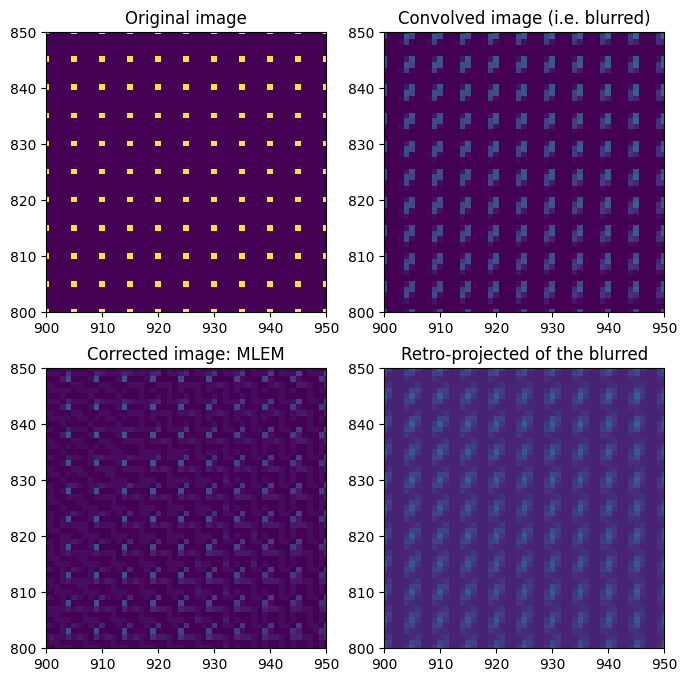

In [21]:
fix, ax = subplots(2,2, figsize=(8,8))
ax[0,0].imshow(dummy_image)
ax[0,1].imshow(dummy_blurred)
ax[1,1].imshow(sparse.T.dot(dummy_blurred.ravel()).reshape(detector.shape))
ax[1,0].imshow(restored_mlem)
ax[0,0].set_xlim(900,950)
ax[0,0].set_ylim(800,850)
ax[0,1].set_xlim(900,950)
ax[0,1].set_ylim(800,850)
ax[1,1].set_xlim(900,950)
ax[1,1].set_ylim(800,850);
ax[1,0].set_xlim(900,950)
ax[1,0].set_ylim(800,850);
ax[0,1].set_title("Convolved image (i.e. blurred)")
ax[0,0].set_title("Original image")
ax[1,1].set_title("Retro-projected of the blurred")
ax[1,0].set_title("Corrected image: MLEM");

In [22]:
# Now the actual image:
%time restored_mlem = deconv_MLEM(sparse, img_blurred, 1e-4).astype("int32")

/tmp/ipykernel_2475388/3212757810.py:5: RuntimeWarning: invalid value encountered in divide
  cor = R.T.dot(M/R.dot(F))


0 67043.34
100 344.76562
200 111.578125
300 51.703125
400 32.85742
500 23.482422
600 17.232422
700 12.964844
800 10.203125
900 8.4375
1000 7.0390625
CPU times: user 14min 30s, sys: 157 ms, total: 14min 30s
Wall time: 14min 31s


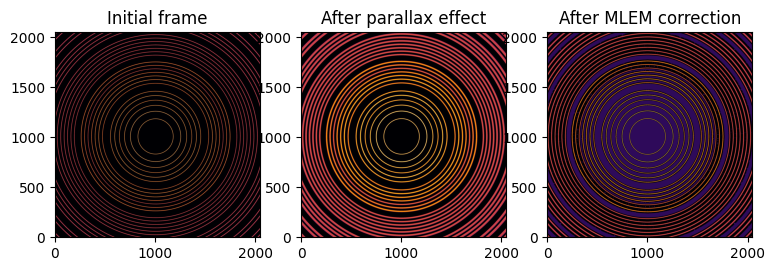

In [23]:
fig, ax = subplots(1,3, figsize=(9,3))
jupyter.display(img, ax=ax[0])
jupyter.display(img_blurred, ax=ax[1])
jupyter.display(restored_mlem, ax=ax[2])
ax[0].set_title("Initial frame")
ax[1].set_title("After parallax effect");
ax[2].set_title("After MLEM correction");

In [24]:
#Save restored data:
with h5py.File("parallax_frames.h5", "r+") as h:
    h.create_dataset("restored_mlem", data=restored_mlem, compression=hdf5plugin.Bitshuffle())

After deconvolution of the parallax effect using MLEM, geometry refines to:
* distance: 70.762mm (δ:762µm)
* energy: 19.966keV (δ:34eV)
* center: 59.999mm (δ:1µm)

Which is not as good as LSMR deconvolution but the image shows fewer artifacts. Note that the deconvolution did not reached its end, it would have requires several more hours for the calculations.

## Conclusion:

We are able to simulate the path and the absorption of the photon in the thickness of the detector. 
The integrated extensions written in parallel Cython helped to make the raytracing calculation substentially faster. 
The signal of each pixel is indeed spread on the neighboors.
This allows to simulate the parallax effect on synthetic calibration frames and can be used to revert the effect of parallax as a sparse-matrix pseudo-inversion. LSMR and MLEM algorithms were investigated:
* LSMR
    + Better conservation of the geometry
    - More graphical artefacts
    - Not very fast but reached convergence
* MLEM
    + Fewer artefacts in the image
    - Not as good when it comes to the geometry conservation
    - Even slower: did not even reach convergence

It is noticeable that an "average" parallax effect can be evaluated in the geometry module of pyFAI which provides a convieniant way to take this effect into account. It is much faster (fractions of a second) than any deconvolution method presented (instead of dozens of minutes) here but not as precise since it is an average method.

In [25]:
print(f"Total execution time: {time.perf_counter()-start_time:.3f} s")

Total execution time: 3709.073 s
